# 피마 인디언 당뇨병 데이터

- 데이터 활용 목적 : 당뇨병 여부를 판단하는 머신러닝 예측 모델을 개발
- 데이터 개요
    - 북아메리카 피마 지역 원주민의 Type-2 당뇨병 결과 데이터
    - 일반적으로 알려진 당뇨벙의 원인은 식습관과 유전
        - 피마 지역은 고립된 지역에서 인디언 고유의 혈통이 지속됨
        - 20세기 후반 서구화된 식습관으로 많은 당뇨 환자가 발생

    - 피처
        - Pregnancies : 임신 횟수
        - Glucose : 포도당 부하 검사 수치
        - BloodPressure : 혈압(mm Hg)
        - SkinThickness : 팔 삼두근 뒤쪽의 피하지방 측정값(mm)
        - Insulin : 혈청 인슐린(mm U/ml)
        - BMI : 체질량 지수 (체중(kg) / 키(m))^2
        - DiabetesPedigreeFuction : 당뇨 내력 가중치 값
        - Age : 나이
        - Outcome : 클래스 결정 값(0 또는 1)

AUC f1 score 정밀도

In [159]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, Binarizer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import (
    accuracy_score,
    recall_score,
    roc_auc_score,
    f1_score,
    confusion_matrix,
    precision_score,
    roc_curve,
)


from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm

## 데이터 준비

In [97]:
df = pd.read_csv("./data/diabetes.csv")

In [98]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [99]:
df["Outcome"].value_counts()

Outcome
0    500
1    268
Name: count, dtype: int64

- 상대적으로 0인 데이터가 많음

In [100]:
df.info()
# 결측값 없음, object 타입 없음

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [101]:
def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    roc_auc = roc_auc_score(y_test, pred_proba)

    print("오차 행렬")
    print(confusion)
    print(
        f"정확도: {accuracy:.4f}, 정밀도 : {precision:.4f}, 재현율: {recall:.4f}, f1: {f1:.4f}, AUC:{roc_auc:.4f}"
    )

In [102]:
def precision_recall_curve_plot(y_test=None, pred_proba_c1=None):
    # threshold ndarray와 threshoold에 따른 정밀도, 재현율 ndarray 추출
    precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_c1)

    # x축을 threshold 값으로 y축은 정밀도, 재현율값으로 각각 시각화 수행
    plt.figure(figsize=(8, 6))
    threshold_boundary = thresholds.shape[0]
    plt.plot(
        thresholds, precisions[:threshold_boundary], linestyle="--", label="precision"
    )
    plt.plot(thresholds, recalls[:threshold_boundary], label="recall")

    # threshold 값 x축의 단위를 0.1 단위로 변경
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1), 2))

    # x축, y축 label과 legend, grid 설정
    plt.xlabel("Threshold value")
    plt.ylabel("Precision & Recall value")
    plt.legend()
    plt.grid()
    plt.show()

In [103]:
df.describe()
# 평균, 분산 차이있음 스케일링 필요

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [104]:
df_corr = df.corr()

## 데이터 시각화

c:\ProgramData\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


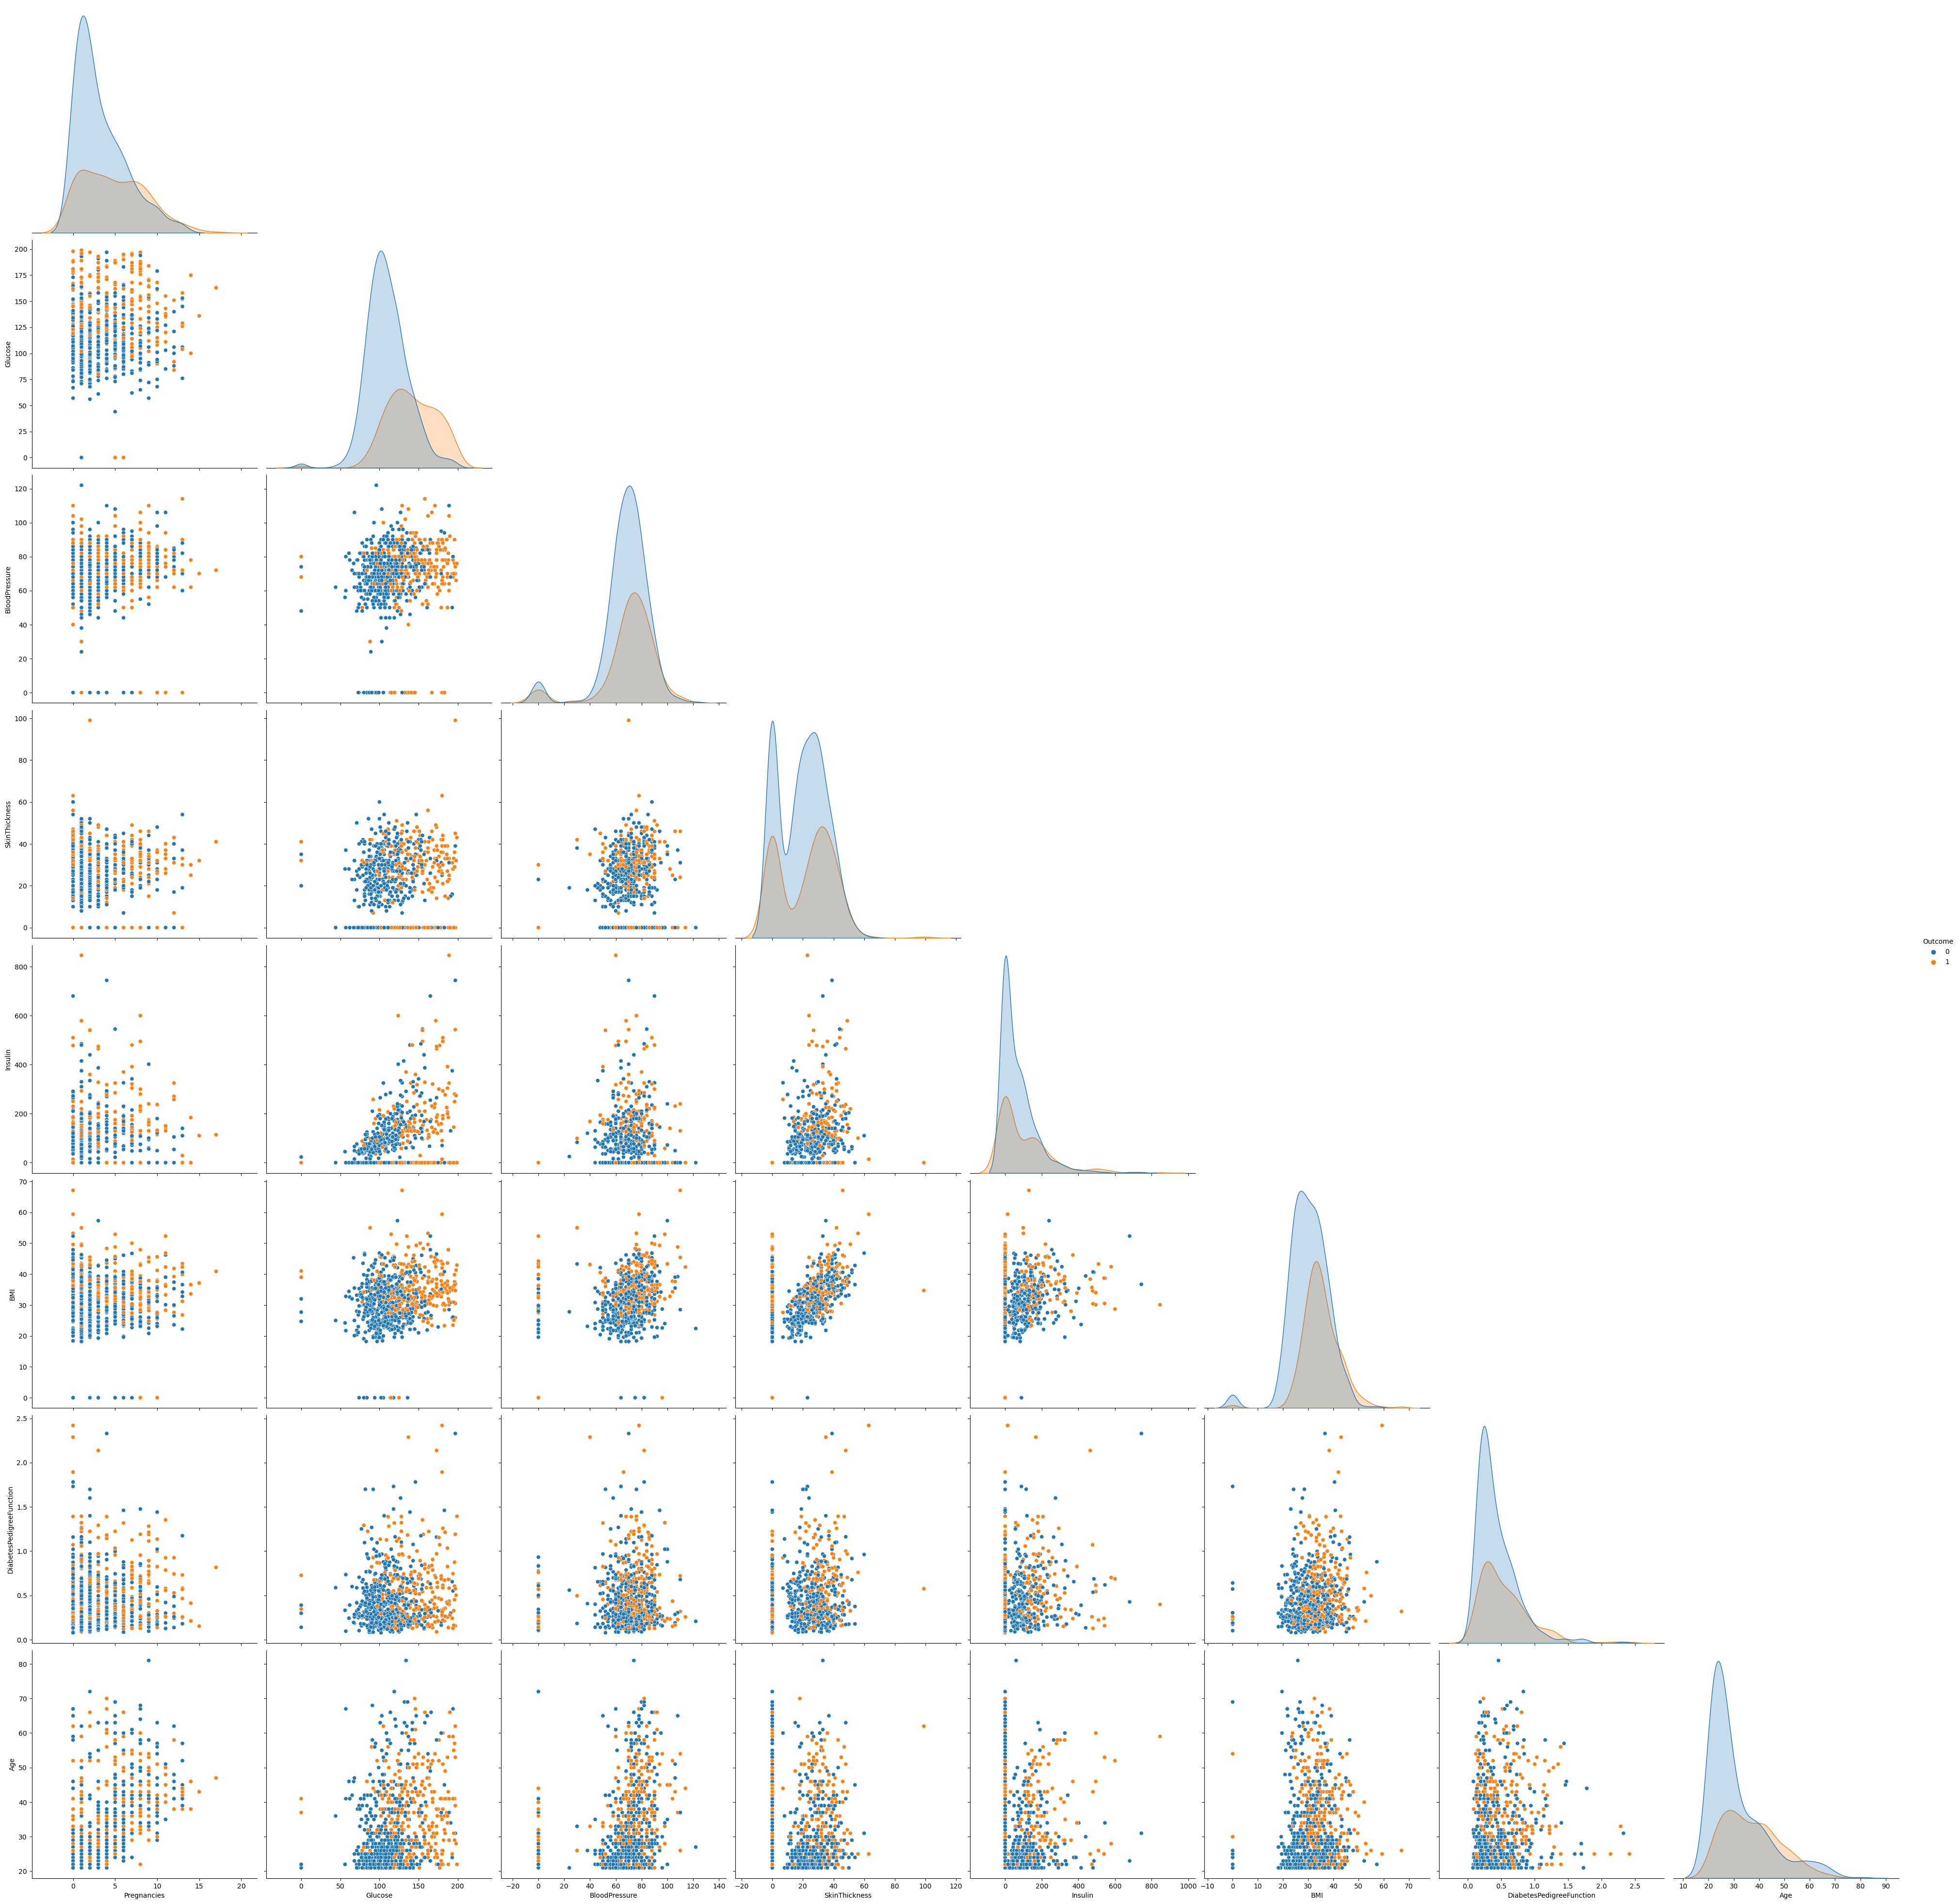

In [105]:
sns.pairplot(df, hue="Outcome", corner=True, height=5)

- 종모양을 띈 Glucose, BloodPressure, BMI

<Axes: >

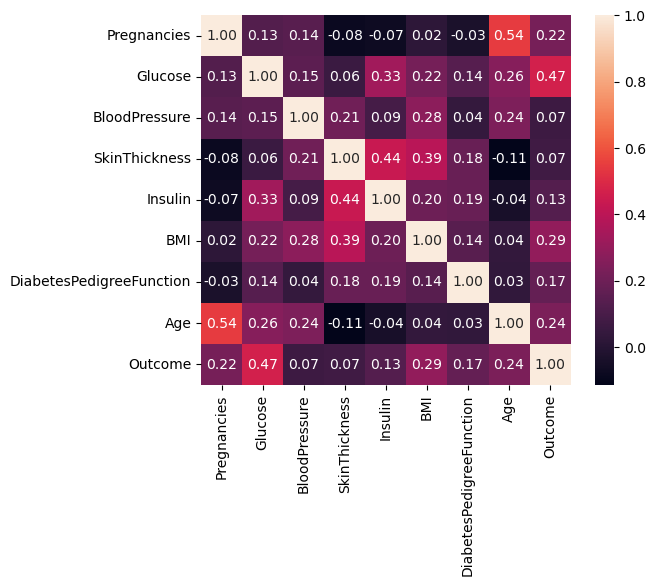

In [106]:
df_corr = df.corr()
sns.heatmap(
    df_corr,
    cbar=True,
    annot=True,
    square=True,
    fmt=".2f",
    annot_kws={"size": 10},
    yticklabels=df_corr,
    xticklabels=df_corr,
)

- Glucose이 가장 영향이 큰것으로 보이고 BloodPressure, SkinThickness는 영향이 가장 적은것으로 보임

<Axes: xlabel='Outcome', ylabel='Glucose'>

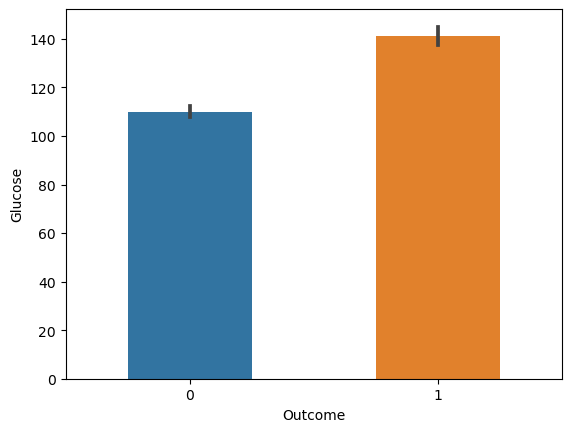

In [107]:
sns.barplot(data=df, x="Outcome", y="Glucose", width=0.5)

## 데이터 변환

In [108]:
x = df.drop("Outcome", axis=1)
y = df["Outcome"]

In [109]:
x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y, random_state=3056)

In [110]:
ss = StandardScaler()
scaled_train = ss.fit_transform(x_train)
scaled_test = ss.transform(x_test)

## 모델 선택

- 당뇨를 판별(1, 0)하는 것이기 때문에 분류 모델을 사용하는 것이 적합해보임

### 의사결정나무

In [111]:
dt = DecisionTreeClassifier(random_state=3056)
dt.fit(scaled_train, y_train)

DecisionTreeClassifier(random_state=3056)

In [112]:
print(dt.score(scaled_test, y_test))

0.6822916666666666


### 랜덤포레스트

In [113]:
rf = RandomForestClassifier(random_state=3056)
rf.fit(scaled_train, y_train)

RandomForestClassifier(random_state=3056)

In [114]:
print(rf.score(scaled_test, y_test))

0.7083333333333334


## baseline 모델

In [115]:
x = df.iloc[:, :-1]
y = df.iloc[:, -1]

In [116]:
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=11, stratify=y
)

In [117]:
x_train.shape, x_test.shape

((614, 8), (154, 8))

In [118]:
# baseline 로지스틱회귀
lr_clf1 = LogisticRegression(random_state=11)
lr_clf1.fit(x_train, y_train)
pred_1 = lr_clf1.predict(x_test)
pred_proba1 = lr_clf1.predict_proba(x_test)[:, 1]

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [119]:
get_clf_eval(y_test, pred_1, pred_proba1)

오차 행렬
[[89 11]
 [24 30]]
정확도: 0.7727, 정밀도 : 0.7317, 재현율: 0.5556, f1: 0.6316, AUC:0.8461


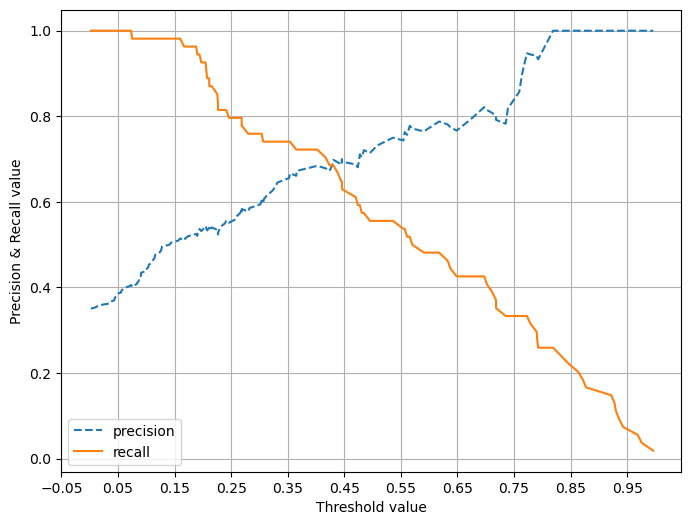

In [120]:
pred_proba_c1 = lr_clf1.predict_proba(x_test)[:, 1]
precision_recall_curve_plot(y_test, pred_proba_c1)

- 임계값이 대략 0.44 정도에서 정밀도와 재현율이 균형을 맞출 것으로 보임
- 점수를 더 높이기 위해 데이터 전처리 수행

# 데이터 전처리

In [121]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


- 데이터 값의 최솟값이 0인 피처가 존재
    - 포도당, 혈압, 피하지방, 인슐린, BMI가 0인 것은 납득하기 어려움

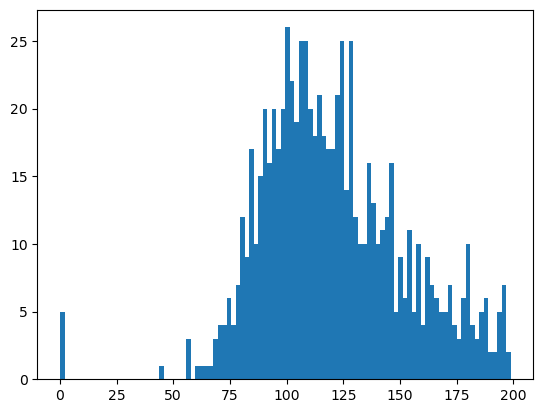

In [128]:
plt.hist(df["Glucose"], bins=100)
plt.show()

- 포도당이 0인 데이터가 5개 존재

In [129]:
# 0값을 검사할 피처명 리스트
zero_features = ["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"]

In [131]:
# 전체 데이터 건수
total_count = df["Glucose"].count()

In [132]:
# 피처별로 반복하면서 데이터 값이 0인 데이터 건수를추출하고, 비율 계산
for feature in zero_features:
    zero_count = df[df[feature] == 0][feature].count()
    print(f"{feature} 0 건수는 {zero_count}, 비율은 {100*zero_count/total_count:.2f}")

Glucose 0 건수는 5, 비율은 0.65
BloodPressure 0 건수는 35, 비율은 4.56
SkinThickness 0 건수는 227, 비율은 29.56
Insulin 0 건수는 374, 비율은 48.70
BMI 0 건수는 11, 비율은 1.43


- SkinThickness와 Insulin의 0값 비율이 꽤 높은 편이어서 데이터 일괄 삭제시 오히려 모델 학습에 악영향을 줄 수 있음
    - 이상치를 평균값으로 대체

In [133]:
# zero_features 리스트 내부에 저장된 개별 피처들에 대해서 0값을 평균값으로 대체
mean_zero_features = df[zero_features].mean()
mean_zero_features

Glucose          120.894531
BloodPressure     69.105469
SkinThickness     20.536458
Insulin           79.799479
BMI               31.992578
dtype: float64

In [134]:
df[zero_features] = df[zero_features].replace(0, mean_zero_features)

In [135]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,121.681605,72.254807,26.606479,118.660163,32.450805,0.471876,33.240885,0.348958
std,3.369578,30.436016,12.115932,9.631241,93.080358,6.875374,0.331329,11.760232,0.476951
min,0.000000,44.000000,24.000000,7.000000,14.000000,18.200000,0.078000,21.000000,0.000000
25%,1.000000,99.750000,64.000000,20.536458,79.799479,27.500000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,79.799479,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


# 모델 학습 테스트

In [137]:
x = df.iloc[:, :-1]
y = df.iloc[:, -1]

In [138]:
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=11, stratify=y
)

In [139]:
# StandardScaler 를 통해 스케일링 적용
scaler = StandardScaler()
scaled_train = scaler.fit_transform(x_train)
scaled_test = scaler.transform(x_test)

In [141]:
# 로지스틱 회귀 학습, 예측, 평가
lr_clf2 = LogisticRegression(random_state=11)
lr_clf2.fit(scaled_train, y_train)
pred2 = lr_clf2.predict(scaled_test)
pred_proba2 = lr_clf2.predict_proba(scaled_test)[:, 1]

In [142]:
get_clf_eval(y_test, pred2, pred_proba2)

오차 행렬
[[88 12]
 [25 29]]
정확도: 0.7597, 정밀도 : 0.7073, 재현율: 0.5370, f1: 0.6105, AUC:0.8461


In [152]:
logi = LogisticRegression(random_state=11)

param = {
    "penalty": ["l1", "l2", "elasticnet", None],
    "C": [0.01, 0.1, 1, 10, 20],
    "solver": ["lbfgs", "liblinear", "newton-cg", "newton-cholesky", "sag", "saga"],
}

splitter = StratifiedKFold(n_splits=5, shuffle=True, random_state=11)
gs = GridSearchCV(logi, param, scoring="roc_auc", cv=splitter, n_jobs=-1)
gs.fit(scaled_train, y_train)

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
275 fits failed out of a total of 600.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
25 fits failed with the following error:
Traceback (most recent call last):
  File "c:\ProgramData\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=11, shuffle=True),
             estimator=LogisticRegression(random_state=11), n_jobs=-1,
             param_grid={'C': [0.01, 0.1, 1, 10, 20],
                         'penalty': ['l1', 'l2', 'elasticnet', None],
                         'solver': ['lbfgs', 'liblinear', 'newton-cg',
                                    'newton-cholesky', 'sag', 'saga']},
             scoring='roc_auc')

In [153]:
gs.best_params_

{'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}

In [154]:
lr_clf3 = gs.best_estimator_

In [155]:
pred3 = lr_clf3.predict(scaled_test)
pred_proba3 = lr_clf3.predict_proba(scaled_test)[:, 1]

In [156]:
get_clf_eval(y_test, pred3, pred_proba3)

오차 행렬
[[88 12]
 [23 31]]
정확도: 0.7727, 정밀도 : 0.7209, 재현율: 0.5741, f1: 0.6392, AUC:0.8400


# 모델 성능 평가

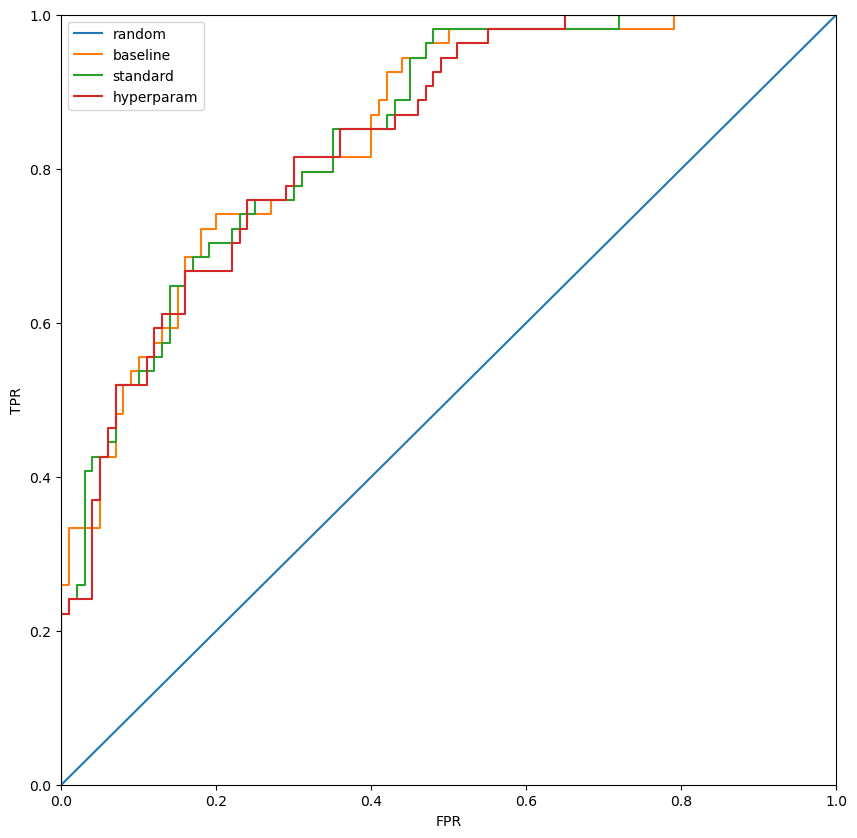

In [158]:
fpr1, tpr1, threshold1 = roc_curve(y_test, pred_proba1)
fpr2, tpr2, threshold2 = roc_curve(y_test, pred_proba2)
fpr3, tpr3, threshold3 = roc_curve(y_test, pred_proba3)

plt.figure(figsize=(10, 10))

plt.plot([0, 1], [0, 1], label="random")
plt.plot(fpr1, tpr1, label="baseline")
plt.plot(fpr2, tpr2, label="standard")
plt.plot(fpr3, tpr3, label="hyperparam")

plt.xlabel("FPR")
plt.ylabel("TPR")
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.legend()
plt.show()

In [160]:
def get_eval_by_threshold(y_test, pred_proba_c1, thresholds):
    # threshold 리스트 내의 값을 차례로 반복하면서 검증
    for custom_threshod in thresholds:
        binarizer = Binarizer(threshold=custom_threshod)
        binarizer.fit(pred_proba_c1)
        custom_predict = binarizer.transform(pred_proba_c1)
        print("임계값: ", custom_threshod)
        get_clf_eval(y_test, custom_predict, pred_proba_c1)
        print("-" * 80)

In [161]:
thresholds = [0.3, 0.33, 0.39, 0.42, 0.45, 0.48, 0.5]

In [162]:
get_eval_by_threshold(y_test, pred_proba1.reshape(-1, 1), thresholds)

임계값:  0.3
오차 행렬
[[72 28]
 [13 41]]
정확도: 0.7338, 정밀도 : 0.5942, 재현율: 0.7593, f1: 0.6667, AUC:0.8461
--------------------------------------------------------------------------------
임계값:  0.33
오차 행렬
[[78 22]
 [14 40]]
정확도: 0.7662, 정밀도 : 0.6452, 재현율: 0.7407, f1: 0.6897, AUC:0.8461
--------------------------------------------------------------------------------
임계값:  0.39
오차 행렬
[[82 18]
 [15 39]]
정확도: 0.7857, 정밀도 : 0.6842, 재현율: 0.7222, f1: 0.7027, AUC:0.8461
--------------------------------------------------------------------------------
임계값:  0.42
오차 행렬
[[82 18]
 [17 37]]
정확도: 0.7727, 정밀도 : 0.6727, 재현율: 0.6852, f1: 0.6789, AUC:0.8461
--------------------------------------------------------------------------------
임계값:  0.45
오차 행렬
[[85 15]
 [21 33]]
정확도: 0.7662, 정밀도 : 0.6875, 재현율: 0.6111, f1: 0.6471, AUC:0.8461
--------------------------------------------------------------------------------
임계값:  0.48
오차 행렬
[[87 13]
 [23 31]]
정확도: 0.7662, 정밀도 : 0.7045, 재현율: 0.5741, f1: 0.6327, AUC:0.8461
--

In [163]:
# 임계값을 0.39로 설정한 Binarizer 생성
binarizer = Binarizer(threshold=0.39)

pred_th = binarizer.fit_transform(pred_proba1.reshape(-1, 1))

In [165]:
get_clf_eval(y_test, pred_th, pred_proba1)

오차 행렬
[[82 18]
 [15 39]]
정확도: 0.7857, 정밀도 : 0.6842, 재현율: 0.7222, f1: 0.7027, AUC:0.8461
